In [1]:
import tifffile as tf
import pandas as pd
import numpy as np
from skimage.transform import hough_circle, hough_circle_peaks
from matplotlib import pyplot as plt
from skimage.filters import threshold_otsu
from skimage.draw import circle_perimeter

In [176]:
tif = tf.TiffFile('/media/marcus/UUI/20200828_FRET_NBD_CALIB1pcNBD_0dot75pc_lissrhod/tifs/Image0017.tif')

In [6]:
print(tif.fluoview_metadata)

{'HeaderFlag': 1454, 'ImageType': 0, 'ImageName': 'Image0017.oif', 'OffsetData': 0, 'PaletteSize': 0, 'OffsetPalette0': 0, 'OffsetPalette1': 0, 'CommentSize': 0, 'OffsetComment': 67108864, 'Dimensions': [('X', 512, 0.0, 0.414, 'µm'), ('Y', 512, 0.0, 0.414, 'µm'), ('Ch', 2, 0.0, 0.0, ''), ('', 1, 0.0, 0.0, ''), ('', 1, 0.0, 0.0, ''), ('', 1, 0.0, 0.0, ''), ('', 1, 0.0, 0.0, ''), ('', 1, 0.0, 0.0, ''), ('', 1, 0.0, 0.0, ''), ('', 1, 0.0, 0.0, '')], 'OffsetPosition': 0, 'MapType': 0, 'MapMin': 0.0, 'MapMax': 4095.0, 'MinValue': 0.0, 'MaxValue': 0.0, 'OffsetMap': 0, 'Gamma': 0.0, 'Offset': 0.0, 'GrayChannel': ('Intensity', 0, 0.0, 1.0, ''), 'OffsetThumbnail': 0, 'VoiceField': 0, 'OffsetVoiceField': 0, 'Stamp': array([0., 0., 0., 0., 0., 0., 0., 0.])}


In [8]:
images = tif.asarray()


In [9]:
print(images.shape)

(2, 512, 512)


In [12]:
%matplotlib qt
fig, ax = plt.subplots(1,2)
names = ['NBD','LissRhod']
for i in range(images.shape[0]):
    ax[i].imshow(images[i],)
    ax[i].set_title(names[i])

# Threshold
## This is done as the GUV in the liss rhod channel is much brighter than the background

In [13]:
def create_bin_edges(image):
    bin_image = np.zeros_like(image)
    # threshold = threshold_otsu(images[1])
    threshold = np.mean(image)+ 3*np.std(image)
    bin_image[image> threshold ] = 1
    return bin_image

In [27]:
plt.figure()
plt.imshow(bin_image)

In [67]:
radii = np.arange(5,30,3)
hough_res = hough_circle(bin_image,radii)


In [68]:
accums,cx,cy,radii = hough_circle_peaks(hough_res,radii,min_xdistance=20,min_ydistance=20)

In [69]:
cx[:8],cy[:8]

(array([348, 346, 193,  10, 393, 278, 193, 261]),
 array([106, 106, 287, 149, 430, 250, 287, 177]))

In [70]:
accums[:8],radii[:8]

(array([1.        , 1.        , 0.94078947, 0.90625   , 0.8125    ,
        0.78125   , 0.66176471, 0.65625   ]),
 array([ 8,  5, 26,  5,  5,  5, 23,  5]))

# Filter peaks for multiple detections
## This is achieved by setting an overlap threshold between pairs of peaks below which the two detections are considered to be from the same true peak.


### Firstly, we don't expect to find more than 8 guvs in one image for example. so we clip the detections to the top 8 detections

In [3]:
def clip_detections(accums,cx,cy,radii,N=8):
    accums = accums[:N]
    cx = cx[:N]
    cy = cy[:N]
    radii = radii[:N]
    return accums,cx,cy,radii


In [86]:
#reshape the peak coordinates to exploit some numpy optimizations

cxcy = np.vstack((cx,cy)).T


In [4]:
def find_duplicates(cxcy):
    #cxcy -> ndarray of shape (N_detections,2): initial detected centre coordinates of circles
    
    for i in range(cxcy.shape[0]):
        peak = cxcy[i]
        rest  = cxcy[i+1:]

        dists = np.linalg.norm(rest - peak,axis = 1)
        if i == 0:

            multi_detections = np.nonzero(dists < 20)[0] +i+1
            
        else:
            multi_detections = np.concatenate((multi_detections,np.nonzero(dists < 20)[0]+i+1))

    return np.unique(multi_detections)

    

In [113]:
to_remove = find_duplicates(cxcy)

In [114]:
to_remove

array([1, 6])

In [5]:
def remove_duplicates(accum,cx,cy,radii,duplicate_coords):
    #accum -> 1darray: ordered results of voting on hough circles
    #cx -> 1darray: most likely x coords by voting
    #cy -> 1darray: most likely y coords by voting
    #duplicate_coords -> 1darray: indices of duplicate detections to remove
    
    accum = np.delete(accum,duplicate_coords)
    cx = np.delete(cx,duplicate_coords)
    cy = np.delete(cy,duplicate_coords)
    radii = np.delete(radii,duplicate_coords)
    return accum,cx,cy,radii

In [117]:
hough_vals = remove_duplicates(accums,cx,cy,radii,duplicate_coords=to_remove)

In [118]:
hough_vals

(array([1.        , 0.94078947, 0.90625   , 0.8125    , 0.78125   ,
        0.65625   ]),
 array([348, 193,  10, 393, 278, 261]),
 array([106, 287, 149, 430, 250, 177]),
 array([ 8, 26,  5,  5,  5,  5]))

In [6]:

def segment_detections(image,hough_vals):
    #image -> ndarray (512,512): raw image 
    #hough_vals -> tuple of 4 1d_arrays : post processed hough circle detection
    ##############  (accumulator,c_x,c_y,radii)
    
    
    detections_img  = np.zeros_like(image)
    i = 1
    for x,y, rad in zip(hough_vals[1],hough_vals[2],hough_vals[3]):

        circy,circx = circle_perimeter(y,x,rad)
        detections_img[circy[circx < 512][circy[circx <512] < 512],circx[circx < 512][circy[circx<512] < 512]] = i
        i +=1
    # plt.imshow(images[1])
    # plt.imshow(detections_img,alpha=1)

    return detections_img

detections_img = segment_detections(images[1],hough_vals)


NameError: name 'images' is not defined

# Create dictionary of guv membrane Intensities for both NBD and LissRhod

In [7]:
#configurations
radii = np.arange(5,30,3)
N = 8

In [15]:


def getFretvals(image_directory,N_image,radii,N=8):
    
    
    membrane_intensities={}
    guv_radii = {}
    
    for frame in range(10,N_image):
        frame = str(frame)
        if len(frame)==1:
            frame = '0'+str(frame)
        try:
            tif = tf.TiffFile(image_directory+'/tifs/Image00'+frame+'.tif')
        except FileNotFoundError:
            continue
        images = tif.asarray()

        #create binary edges for circle detection
        bin_image = create_bin_edges(images[1])

        #circle detection with Hough transform

        hough_res = hough_circle(bin_image,radii)

        hough_vals = hough_circle_peaks(hough_res,radii)

        #clip detections: we don't expect there to be more than a few GUVs in one frame

        hough_vals = clip_detections(*hough_vals,N)

        #reshape the peak coordinates to exploit some numpy optimizations

        cxcy = np.vstack((hough_vals[1],hough_vals[2])).T

        #Due to bug in scikit image hough circle peaks function, need to remove duplicates

        duplicates = find_duplicates(cxcy)

        hough_vals = remove_duplicates(*hough_vals,duplicates)

        #Segment instances of circles to get individual GUV membranes

        detections_img = segment_detections(images[1],hough_vals)

        for _id in np.unique(detections_img):
            membrane_intensities[frame+'_'+str(_id)] = [np.mean(images[0][detections_img==_id]),np.mean(images[1][detections_img == _id])]
            guv_radii[frame+'_'+str(_id)] = len(detections_img[detections_img==_id])/(2*np.pi)
            
            
    return membrane_intensities,guv_radii



In [16]:
membrane_intensities10dot75,guv_radii10dot75 = getFretvals('/home/marcus/20200828_FRET_NBD_CALIB1pcNBD_0dot75pc_lissrhod/',55,radii)

In [17]:
membrane_intensities11,guv_radii11 = getFretvals('/home/marcus/20200827_NBDFRET_CALIB_1pcNBD1pcLissRhod/',32,radii)

In [45]:
membrane_intensities11

{'10_0': [530.2029511978976, 371.0551506539543],
 '10_1': [3670.464285714286, 3673.25],
 '10_2': [701.3214285714286, 2407.6428571428573],
 '10_3': [1078.121212121212, 2362.340909090909],
 '10_4': [1343.7987804878048, 2515.5731707317073],
 '11_0': [525.4025613685092, 372.6978066705649],
 '11_1': [2132.285714285714, 1921.5714285714287],
 '11_2': [1634.3513513513512, 2904.6824324324325],
 '11_3': [914.5909090909091, 1770.3181818181818],
 '11_4': [2469.9285714285716, 1673.9285714285713],
 '11_5': [1006.2142857142857, 2147.6785714285716],
 '11_6': [1493.7073170731708, 2277.7642276422766],
 '12_0': [523.7375352918733, 360.18487981686377],
 '12_1': [2101.931818181818, 3559.25],
 '13_0': [510.2394724381787, 349.67729987322633],
 '13_1': [3688.6428571428573, 2919.5],
 '13_2': [1264.972972972973, 2442.608108108108],
 '13_3': [1947.1785714285713, 1692.3214285714287],
 '13_4': [716.4285714285714, 1172.9642857142858],
 '13_5': [945.5714285714286, 1132.5714285714287],
 '14_0': [513.1656463727406, 35

# Use numpy indexing to filter GUV detections by radius

In [32]:
frets1to0dot75 = {}
for key in membrane_intensities10dot75.keys():
    frets1to0dot75[key] = membrane_intensities10dot75[key][1]/membrane_intensities10dot75[key][0]

In [46]:
frets11 = {}
for key in membrane_intensities11.keys():
    frets11[key] = membrane_intensities11[key][1]/membrane_intensities11[key][0]

In [60]:
frets11data = np.array(list(frets11.values()))
frets11keys = np.array(list(frets11.keys()))
radii11data = np.array(list(guv_radii11.values()))

In [57]:
frets75data = np.array(list(frets1to0dot75.values()))
frets75keys = np.array(list(frets1to0dot75.keys()))
radii75data=np.array(list(guv_radii10dot75.values()))

In [62]:
frets11data = frets11data[radii11data < 30]
frets11keys = frets11keys[radii11data < 30]
radii11data = radii11data[radii11data < 30]

frets11data = frets11data[radii11data >= 15]
frets11keys = frets11keys[radii11data >= 15]
radii11data = radii11data[radii11data >= 15]

In [63]:
frets75data = frets75data[radii75data < 30]
frets75keys = frets75keys[radii75data < 30]
radii75data = radii75data[radii75data < 30]

frets75data = frets75data[radii75data >= 15]
frets75keys = frets75keys[radii75data >= 15]
radii75data = radii75data[radii75data >= 15]

In [68]:
%matplotlib qt
plt.hist(frets11data,10)
plt.hist(frets75data,10)

(array([4., 1., 4., 9., 9., 3., 5., 2., 2., 1.]),
 array([0.63908322, 0.69678491, 0.7544866 , 0.8121883 , 0.86988999,
        0.92759169, 0.98529338, 1.04299507, 1.10069677, 1.15839846,
        1.21610016]),
 <BarContainer object of 10 artists>)

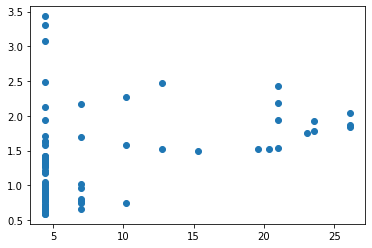

In [29]:
plt.scatter(radii11vals[radii11vals < 30],frets11vals[radii11vals < 30])

(array([63.,  8.,  3.,  2.,  0.,  1.,  1.,  5.,  3.,  3.]),
 array([ 4.45633841,  6.62084563,  8.78535286, 10.94986008, 13.11436731,
        15.27887454, 17.44338176, 19.60788899, 21.77239621, 23.93690344,
        26.10141067]),
 <BarContainer object of 10 artists>)

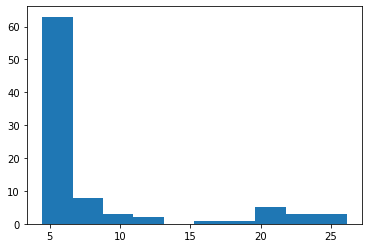

In [31]:
plt.hist(np.array(list(guv_radii11.values()))[np.array(list(guv_radii11.values())) < 30])

In [174]:
fig,ax = plt.subplots(1,1)
ax.hist(frets.values(),bins=30,)
ax.hist(frets11.values(),bins=30)

(array([ 8., 32., 19.,  9.,  7.,  6.,  6., 10.,  4.,  6.,  5.,  8.,  4.,
         3.,  6.,  4.,  1.,  2.,  2.,  3.,  3.,  2.,  1.,  1.,  0.,  0.,
         0.,  1.,  0.,  1.]),
 array([0.54800022, 0.63982362, 0.73164703, 0.82347043, 0.91529384,
        1.00711724, 1.09894065, 1.19076405, 1.28258746, 1.37441086,
        1.46623427, 1.55805768, 1.64988108, 1.74170449, 1.83352789,
        1.9253513 , 2.0171747 , 2.10899811, 2.20082151, 2.29264492,
        2.38446832, 2.47629173, 2.56811514, 2.65993854, 2.75176195,
        2.84358535, 2.93540876, 3.02723216, 3.11905557, 3.21087897,
        3.30270238]),
 <BarContainer object of 30 artists>)

In [165]:
plt.hist(frets11.values(),bins=30)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)